In [39]:
  !pip install -q lightgbm xgboost

In [40]:
!pip install -q seaborn

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 200)
sns.set(style="whitegrid")

In [42]:
df = pd.read_csv('Titanic_train.csv')

print("Loaded dataframe shape:", df.shape)
df.head()


Loaded dataframe shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
# Missing values
print("Missing values per column:\n", df.isnull().sum().sort_values(ascending=False))

# Basic numeric description
display(df.describe().T)

# Quick counts for categorical columns
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    print(f"\nValue counts for {c}:")
    print(df[c].value_counts(dropna=False).head())

Missing values per column:
 Cabin          687
Age            177
Embarked         2
PassengerId      0
Name             0
Pclass           0
Survived         0
Sex              0
Parch            0
SibSp            0
Fare             0
Ticket           0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292



Value counts for Name:
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
Name: count, dtype: int64

Value counts for Sex:
Sex
male      577
female    314
Name: count, dtype: int64

Value counts for Ticket:
Ticket
347082      7
1601        7
CA. 2343    7
3101295     6
CA 2144     6
Name: count, dtype: int64

Value counts for Cabin:
Cabin
NaN            687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
Name: count, dtype: int64

Value counts for Embarked:
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64


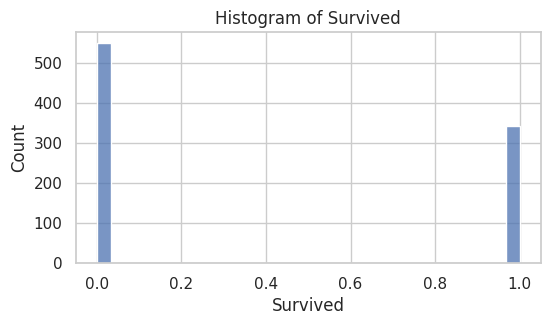

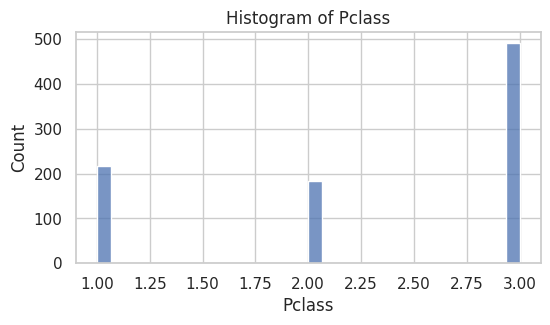

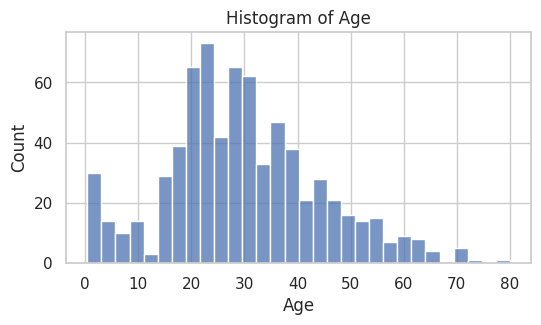

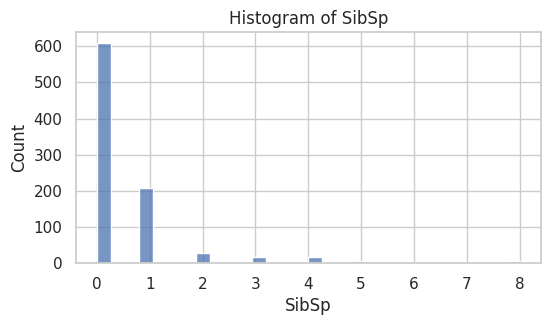

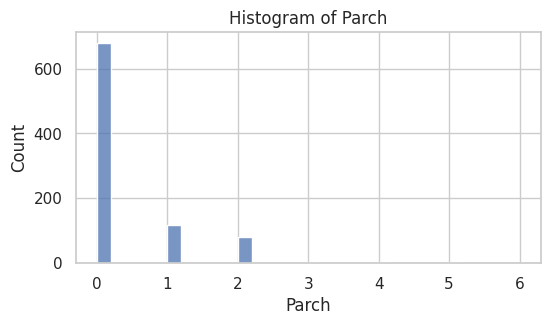

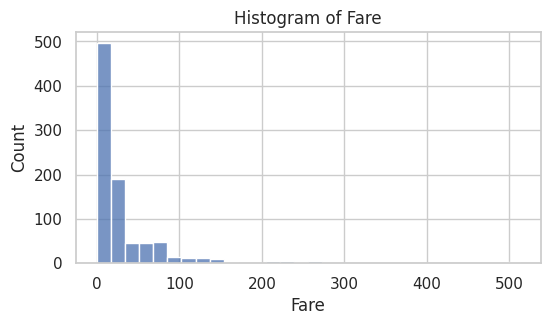

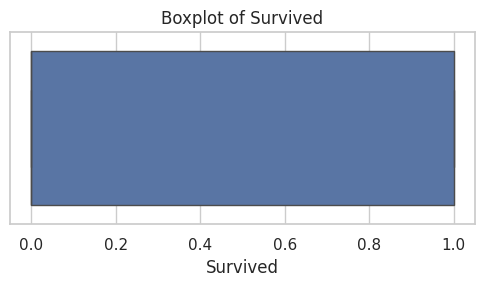

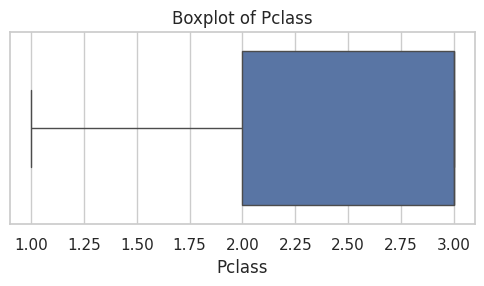

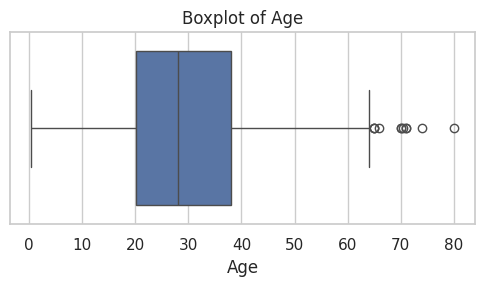

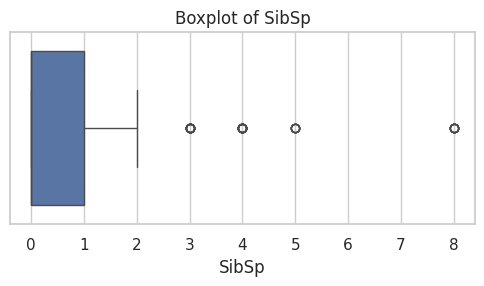

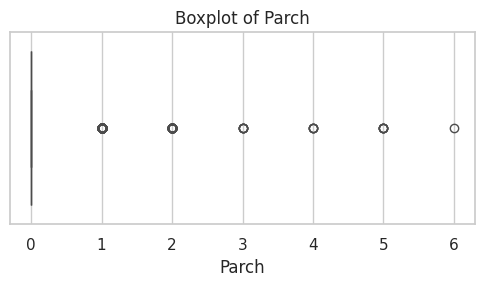

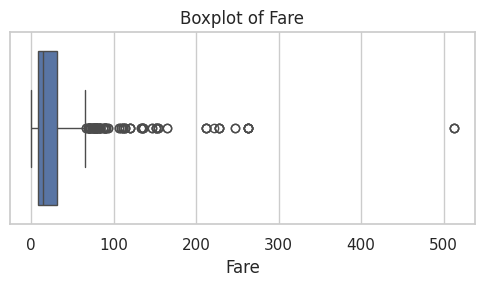

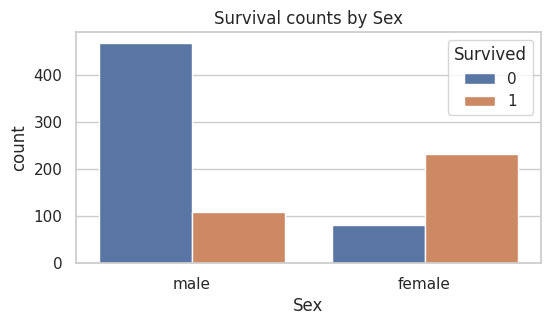

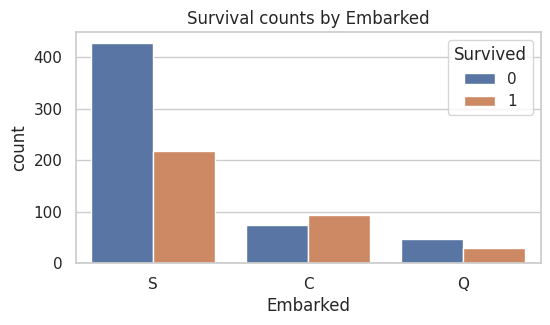

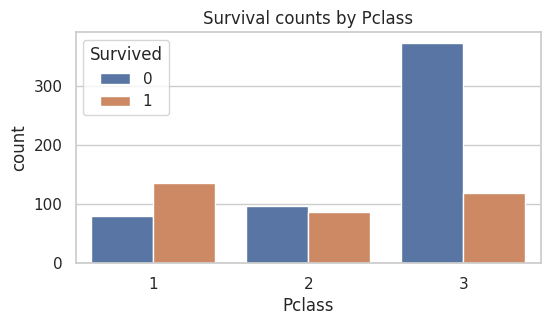

In [44]:
# Visual EDA (histograms, boxplots, categorical survival plots)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Remove meaningless ids if present
numeric_cols = [c for c in numeric_cols if c not in ('PassengerId',)]

# Histograms
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col].dropna(), kde=False, bins=30)
    plt.title(f'Histogram of {col}')
    plt.show()

# Boxplots
for col in numeric_cols:
    plt.figure(figsize=(6,2.5))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Survival by key categorical features
for col in ['Sex','Embarked','Pclass']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.countplot(data=df, x=col, hue='Survived')
        plt.title(f'Survival counts by {col}')
        plt.show()

In [45]:
# Feature engineering
# Common Titanic feature engineering steps: Title, FamilySize, FareBin, AgeBin
df = df.copy()
# Title extraction
if 'Name' in df.columns:
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
    # map rare titles to 'Rare'
    title_counts = df['Title'].value_counts()
    rare_titles = title_counts[title_counts < 10].index.tolist()
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# Family size
if all(col in df.columns for col in ['SibSp','Parch']):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# Fare per person (if family present)
if 'Fare' in df.columns and 'FamilySize' in df.columns:
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']

# Optional bins (uncomment if you want binned features)
# df['FareBin'] = pd.qcut(df['Fare'].fillna(0)+1, 4, labels=False)
# df['AgeBin'] = pd.cut(df['Age'].fillna(df['Age'].median()), bins=[0,12,20,40,60,120], labels=False)

print("After feature engineering, columns:", df.columns.tolist())
display(df.head())


After feature engineering, columns: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'FamilySize', 'FarePerPerson']


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,8.05000


In [46]:
# Select features & target
# Choose a set of features that are commonly useful for Titanic
features = []
for c in ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title','FamilySize','FarePerPerson']:
    if c in df.columns:
        features.append(c)

# Ensure target exists
if 'Survived' not in df.columns:
    raise KeyError("Target column 'Survived' not found in dataset.")

data = df[features + ['Survived']].copy()
display(data.head())
print("Features used:", features)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,FarePerPerson,Survived
0,3,male,22.0,1,0,7.2500,S,Mr,2,3.62500,0
1,1,female,38.0,1,0,71.2833,C,Mrs,2,35.64165,1
2,3,female,26.0,0,0,7.9250,S,Miss,1,7.92500,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2,26.55000,1
4,3,male,35.0,0,0,8.0500,S,Mr,1,8.05000,0


Features used: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'FamilySize', 'FarePerPerson']


In [47]:
# Preprocessing pipeline
# Numeric & categorical split
numeric_features = [c for c in features if df[c].dtype in [np.float64, np.int64]]
# But treat Pclass as categorical if present
if 'Pclass' in numeric_features:
    numeric_features.remove('Pclass')

categorical_features = [c for c in features if c not in numeric_features]

from sklearn.preprocessing import StandardScaler
numeric_transformer = SimpleImputer(strategy='median')  # median imputation

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit transform to produce feature names later
X = data.drop(columns=['Survived'])
y = data['Survived']

X_pre = preprocessor.fit_transform(X)

# Build feature names (for importance plots)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_ohe_cols = []
if categorical_features:
    cat_ohe_cols = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_ohe_cols
print("Transformed feature count:", X_pre.shape[1])
print("Feature names sample:", feature_names[:30])

Transformed feature count: 19
Feature names sample: ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'FarePerPerson', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


In [48]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_pre, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (712, 19) Test shape: (179, 19)


In [49]:
# Helper evaluation function
def evaluate_model(name, model, X_test, y_test, show_report=True):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    if show_report:
        print(f"\n=== {name} Evaluation ===")
        print("Accuracy:", round(acc,4))
        print("Precision:", round(prec,4))
        print("Recall:", round(rec,4))
        print("F1-score:", round(f1,4))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return {'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'y_pred': y_pred}


In [50]:
# LightGBM training with GridSearchCV
# Set up LightGBM classifier and a small grid for demo. Expand grid for better tuning.
lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1)

lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, -1],
    'learning_rate': [0.05, 0.1]
}

# Use StratifiedKFold for consistent CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lgb_gs = GridSearchCV(lgb_clf, lgb_param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

print("Training LightGBM (GridSearchCV)...")
lgb_gs.fit(X_train, y_train)

print("Best LightGBM params:", lgb_gs.best_params_)
best_lgb = lgb_gs.best_estimator_

res_lgb = evaluate_model("LightGBM", best_lgb, X_test, y_test)

Training LightGBM (GridSearchCV)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [51]:
# XGBoost training with GridSearchCV
# Set up XGBoost classifier and a small grid for demo. Expand grid for better tuning.
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Use StratifiedKFold for consistent CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_gs = GridSearchCV(xgb_clf, xgb_param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

print("Training XGBoost (GridSearchCV)...")
xgb_gs.fit(X_train, y_train)

print("Best XGBoost params:", xgb_gs.best_params_)
best_xgb = xgb_gs.best_estimator_

res_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)

Training XGBoost (GridSearchCV)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

=== XGBoost Evaluation ===
Accuracy: 0.8101
Precision: 0.7869
Recall: 0.6957
F1-score: 0.7385

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix:
 [[97 13]
 [21 48]]


,accuracy,precision,recall,f1
model,,,,
LightGBM,0.8101,0.7778,0.7101,0.7424
XGBoost,0.8101,0.7869,0.6957,0.7385


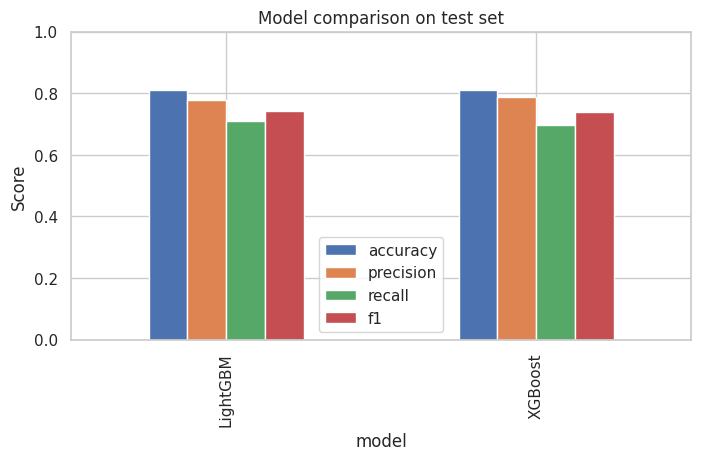

In [52]:
# Compare models (metrics & visualization)
results = [res_lgb, res_xgb]  # use only trained results
comp_df = pd.DataFrame(results).set_index('model')[['accuracy','precision','recall','f1']]
display(comp_df.round(4))

# Plot comparison
comp_df.plot(kind='bar', figsize=(8,4))
plt.title("Model comparison on test set")
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()

In [53]:
# XGBoost training with GridSearchCV
# Set up XGBoost classifier and a small grid for demo. Expand grid for better tuning.
xgb_clf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

# Use StratifiedKFold for consistent CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_gs = GridSearchCV(xgb_clf, xgb_param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=1)

print("Training XGBoost (GridSearchCV)...")
xgb_gs.fit(X_train, y_train)

print("Best XGBoost params:", xgb_gs.best_params_)
best_xgb = xgb_gs.best_estimator_

res_xgb = evaluate_model("XGBoost", best_xgb, X_test, y_test)

Training XGBoost (GridSearchCV)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best XGBoost params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

=== XGBoost Evaluation ===
Accuracy: 0.8101
Precision: 0.7869
Recall: 0.6957
F1-score: 0.7385

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

Confusion Matrix:
 [[97 13]
 [21 48]]


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [18:57:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


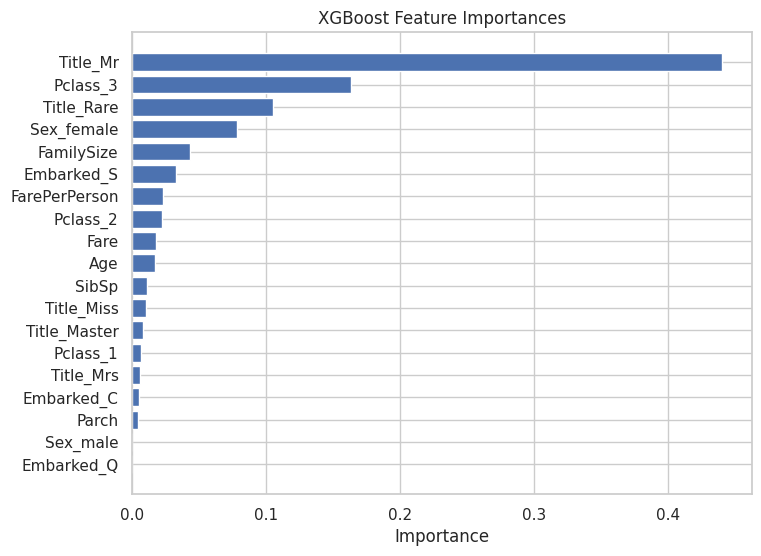

In [54]:
# Plot XGBoost feature importances
try:
    imp = best_xgb.feature_importances_
    fi = pd.DataFrame({'feature': feature_names, 'importance': imp})
    fi = fi.sort_values('importance', ascending=True)
    plt.figure(figsize=(8,6))
    plt.barh(fi['feature'], fi['importance'])
    plt.title('XGBoost Feature Importances')
    plt.xlabel('Importance')
    plt.show()
except Exception as e:
    print("Could not plot XGBoost importances:", e)


,accuracy,precision,recall,f1
model,,,,
LightGBM,0.8101,0.7778,0.7101,0.7424
XGBoost,0.8101,0.7869,0.6957,0.7385


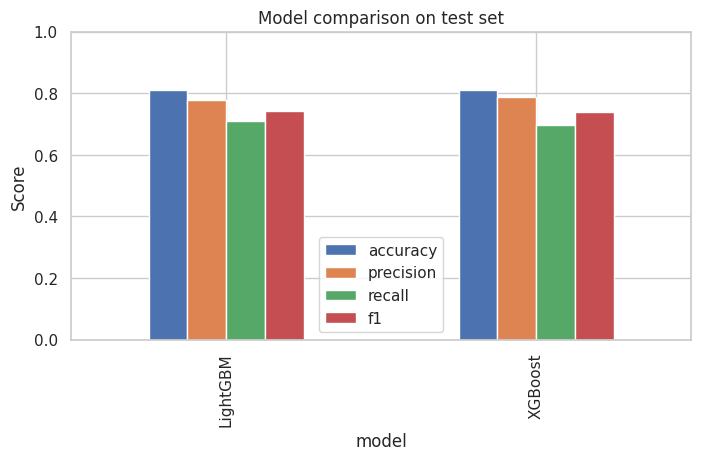

In [55]:
# Compare models (metrics & visualization)
results = [res_lgb, res_xgb]  # use only trained results
comp_df = pd.DataFrame(results).set_index('model')[['accuracy','precision','recall','f1']]
display(comp_df.round(4))

# Plot comparison
comp_df.plot(kind='bar', figsize=(8,4))
plt.title("Model comparison on test set")
plt.ylim(0,1)
plt.ylabel("Score")
plt.show()


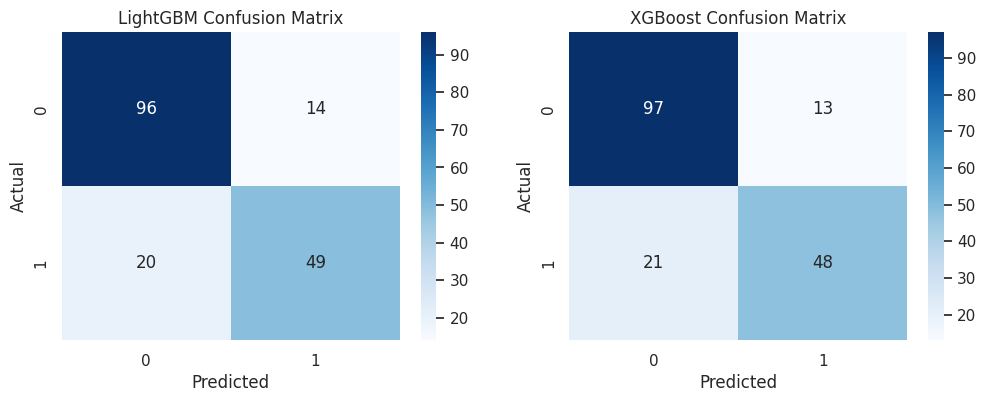

In [56]:
# Confusion matrices side-by-side
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(12,4))
for ax, res, name in zip(axes, [res_lgb, res_xgb], ['LightGBM','XGBoost']):
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.show()


In [57]:
best_by = comp_df['f1'].idxmax()
print(f"- Best model by F1-score: {best_by}")
comp_df.round(4)

- Best model by F1-score: LightGBM


,accuracy,precision,recall,f1
model,,,,
LightGBM,0.8101,0.7778,0.7101,0.7424
XGBoost,0.8101,0.7869,0.6957,0.7385


- Note:
  * Try broader hyperparameter search (RandomizedSearch or Optuna) for production.
  * Consider ensembling (stacking or averaging LightGBM + XGBoost).
  * Add cross-feature interactions and more feature engineering (Age bins, Fare bins, Ticket frequency).
  * If using this in production, evaluate with cross-validated metrics and check calibration.
